In [191]:
import polars as pl
from pathlib import Path
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from functime.feature_extractors import FeatureExtractor

In [192]:
ts_sensor_path = Path(os.path.abspath("")).parents[1] / "data" / "ts_data"/ "ts_sensor_data.csv"

ts_sensor_data = pl.read_csv(source=ts_sensor_path)
ts_sensor_data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,"""2018-04-01 00:00:00""",2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,15.05353,37.2274,47.52422,31.11716,1.681353,419.5747,null,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.674,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,"""NORMAL"""
1,"""2018-04-01 00:01:00""",2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,15.05353,37.2274,47.52422,31.11716,1.681353,419.5747,null,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.674,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,"""NORMAL"""
2,"""2018-04-01 00:02:00""",2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.848,null,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.239,778.5734,715.6266,661.574,721.875,694.7721,441.2635,169.982,343.1955,200.9694,93.90508,41.40625,31.25,69.53125,30.46875,31.77083,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,"""NORMAL"""
3,"""2018-04-01 00:03:00""",2.460474,47.09201,53.1684,46.397568,628.125,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,null,462.898,460.8858,2.509521,666.0114,399.1046,878.8917,499.043,977.752,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.0406,41.92708,31.51042,72.13541,30.46875,31.51042,40.88541,39.0625,64.81481,51.21528,38.19444,155.9606,66.84028,240.4514,203.125,"""NORMAL"""
4,"""2018-04-01 00:04:00""",2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,null,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.183,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.963,193.877,101.7038,42.70833,31.51042,76.82291,30.98958,31.51042,41.40625,38.77315,65.10416,51.79398,38.77315,158.2755,66.55093,242.1875,201.3889,"""NORMAL"""


In [193]:
## cast timestamp column to datetime
ts_sensor_data = ts_sensor_data.with_columns(
    pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S").alias("timestamp")).sort(by=["timestamp"])


sensor_columns = [col for col in ts_sensor_data.columns if col not in ['timestamp', 'machine_status', '']]

ts_sensor_data = ts_sensor_data.with_columns([
    pl.col(col).cast(pl.Float64, strict=False) for col in sensor_columns
])

In [194]:
def generate_features_for_timeseries(column_name: str) -> dict:
    ts = pl.col(column_name).ts
    return {
        f"mean_n_absolute_max_{column_name}": ts.mean_n_absolute_max(n_maxima=3),
        f"range_over_mean_{column_name}": ts.range_over_mean(),
        f"root_mean_square_{column_name}": ts.root_mean_square(),
        f"first_location_of_maximum_{column_name}": ts.first_location_of_maximum(),
        f"last_location_of_maximum_{column_name}": ts.last_location_of_maximum(),
        f"absolute_maximum_{column_name}": ts.absolute_maximum()
    }

new_features = {
    feature_name: calculation
    for sensor_column in sensor_columns
    for feature_name, calculation in generate_features_for_timeseries(sensor_column).items()
}

timeseries_features = (
    ts_sensor_data.group_by_dynamic(
        index_column="timestamp",
        every="3h",
        group_by="machine_status",
        start_by="window"
    )
    .agg(**new_features)
)
timeseries_features.shape

(1244, 314)

In [195]:
timeseries_features = timeseries_features.to_pandas().dropna(axis=1)
X = timeseries_features[timeseries_features.columns[2:]]
y = timeseries_features["machine_status"]

selector = SelectKBest(score_func=f_classif, k=30).set_output(transform="pandas")
X_selected = selector.fit_transform(X, y)
X.shape

(1244, 252)

In [196]:
X = timeseries_features[timeseries_features.columns[2:]]
y = timeseries_features["machine_status"]

selector = SelectKBest(score_func=f_classif, k=30).set_output(transform="pandas")
X_selected = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

model = HistGradientBoostingClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

      BROKEN       1.00      1.00      1.00         2
      NORMAL       0.99      1.00      1.00       346
  RECOVERING       0.96      0.92      0.94        26

    accuracy                           0.99       374
   macro avg       0.98      0.97      0.98       374
weighted avg       0.99      0.99      0.99       374



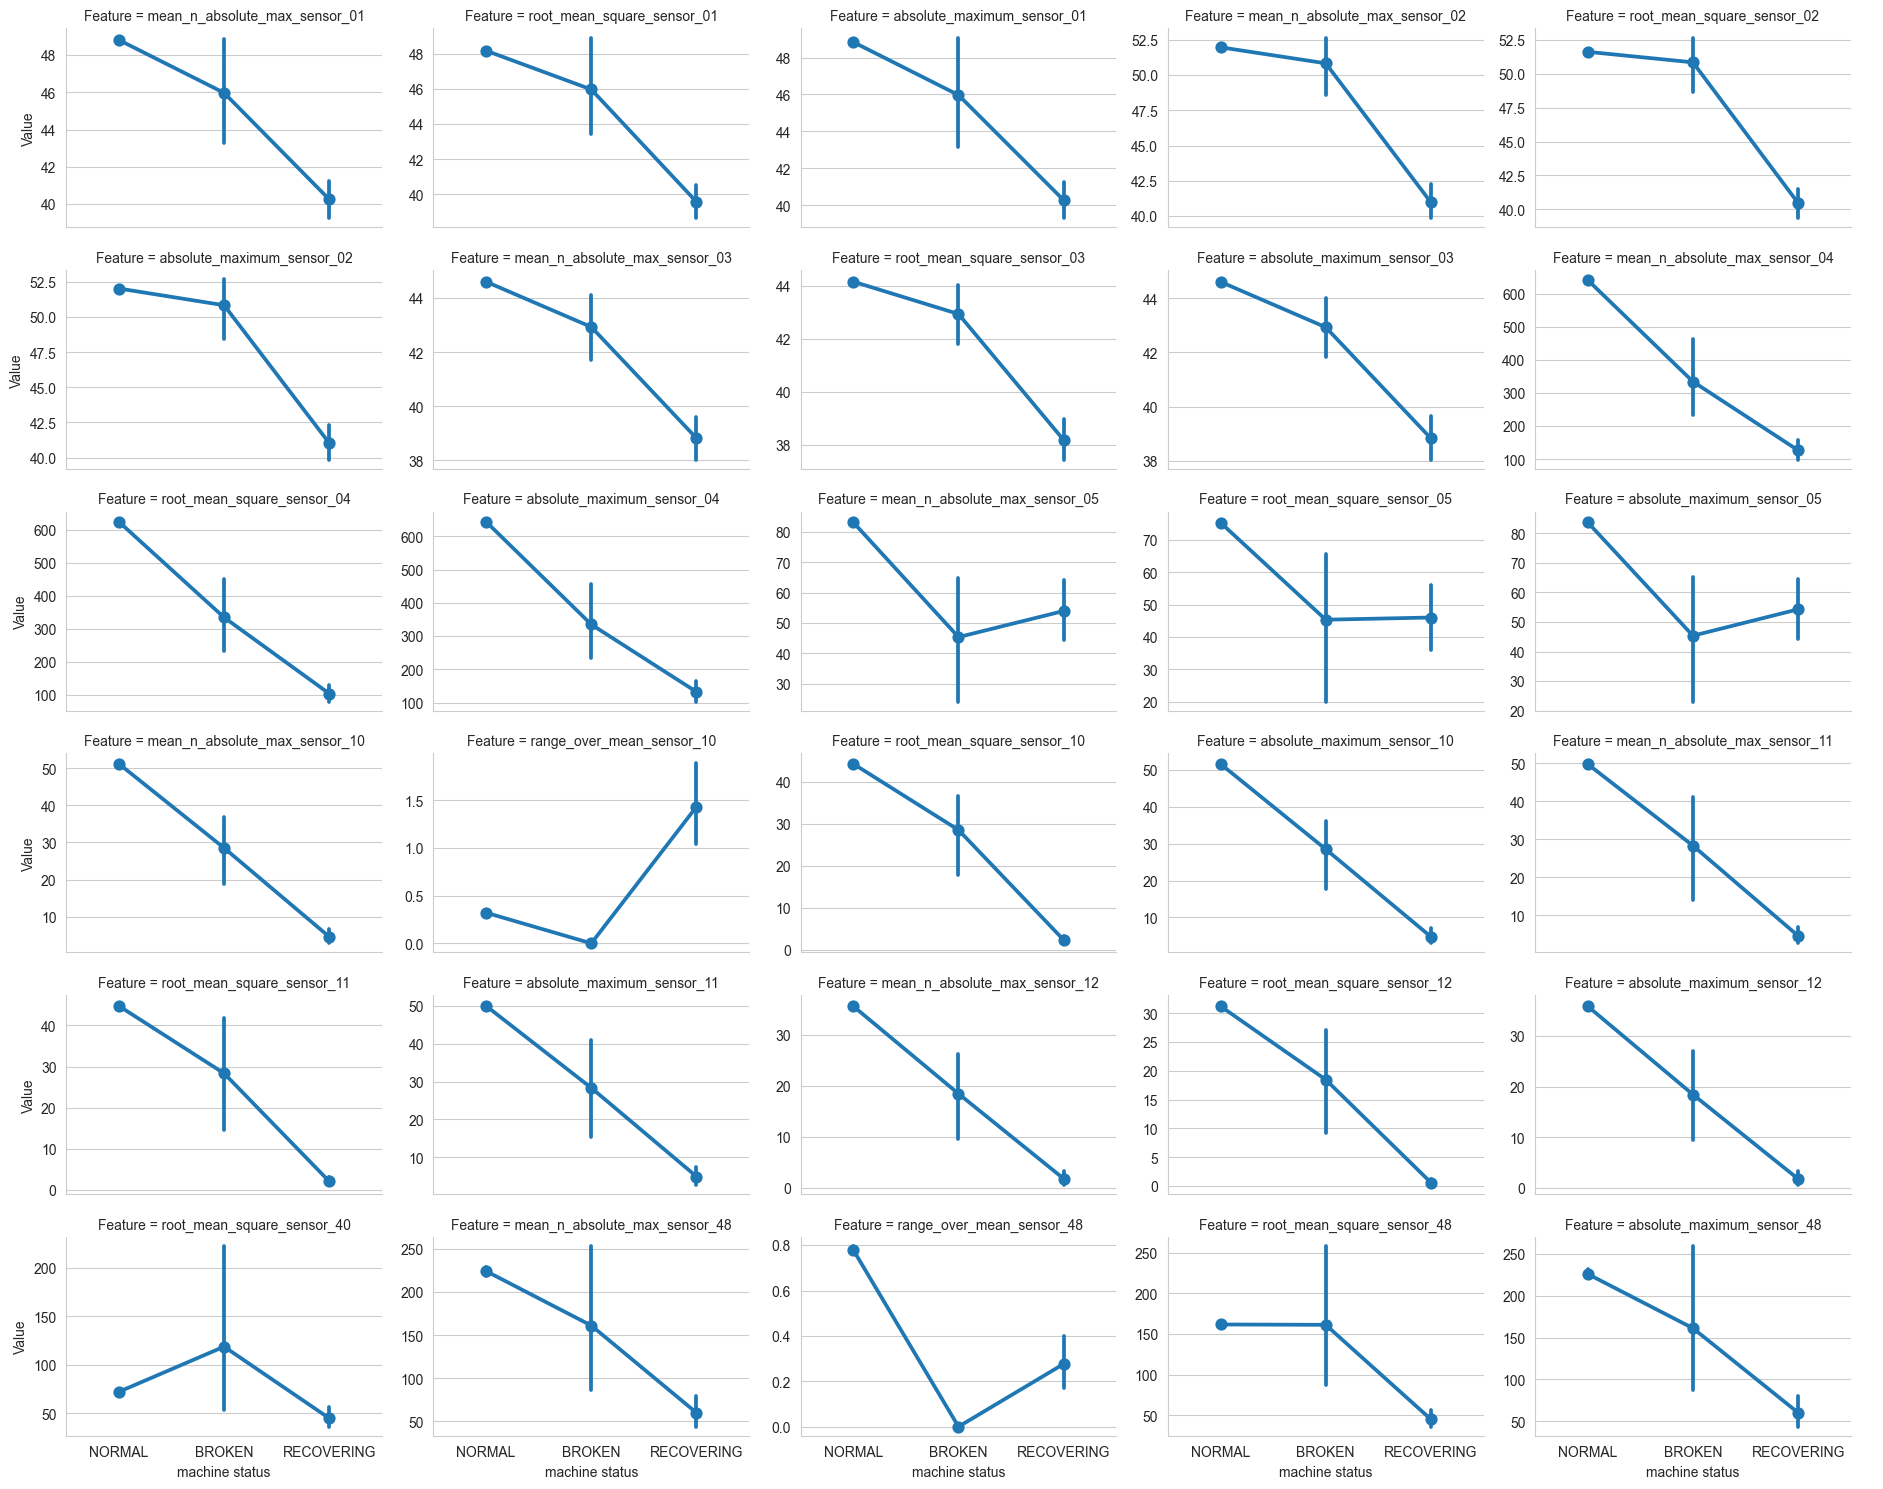

In [197]:
melted_df = timeseries_features.melt(
    id_vars=["machine_status"],
    value_vars=X_selected.columns,
    var_name="Feature",
    value_name="Value"
)
g = sns.catplot(
    data=melted_df,
    x="machine_status",
    y="Value",
    col="Feature",
    kind="point",
    height=2.5,
    aspect=1.5,
    col_wrap=5,
    sharex=True,
    sharey=False,
)

g.set_xlabels("machine status")
plt.show()